Epoch 0: Train Loss = 3.5033, Val Loss = 3.4965, Train Acc = 0.0396, Val Acc = 0.0373
Epoch 10: Train Loss = 3.5027, Val Loss = 3.4959, Train Acc = 0.0533, Val Acc = 0.0495
Epoch 20: Train Loss = 3.0726, Val Loss = 3.0291, Train Acc = 0.0966, Val Acc = 0.0953
Epoch 30: Train Loss = 2.3341, Val Loss = 2.2759, Train Acc = 0.3049, Val Acc = 0.3003
Epoch 40: Train Loss = 1.5625, Val Loss = 1.5408, Train Acc = 0.5117, Val Acc = 0.4882
Epoch 50: Train Loss = 1.0960, Val Loss = 1.0698, Train Acc = 0.6635, Val Acc = 0.6422
Epoch 60: Train Loss = 0.7771, Val Loss = 0.7472, Train Acc = 0.7711, Val Acc = 0.7367
Epoch 70: Train Loss = 0.5665, Val Loss = 0.5588, Train Acc = 0.8214, Val Acc = 0.7798
Epoch 80: Train Loss = 0.4245, Val Loss = 0.4190, Train Acc = 0.8692, Val Acc = 0.8153
Epoch 90: Train Loss = 0.3293, Val Loss = 0.3082, Train Acc = 0.9102, Val Acc = 0.8465

Classification report:
              precision    recall  f1-score   support

          ya       0.93      0.94      0.93       17

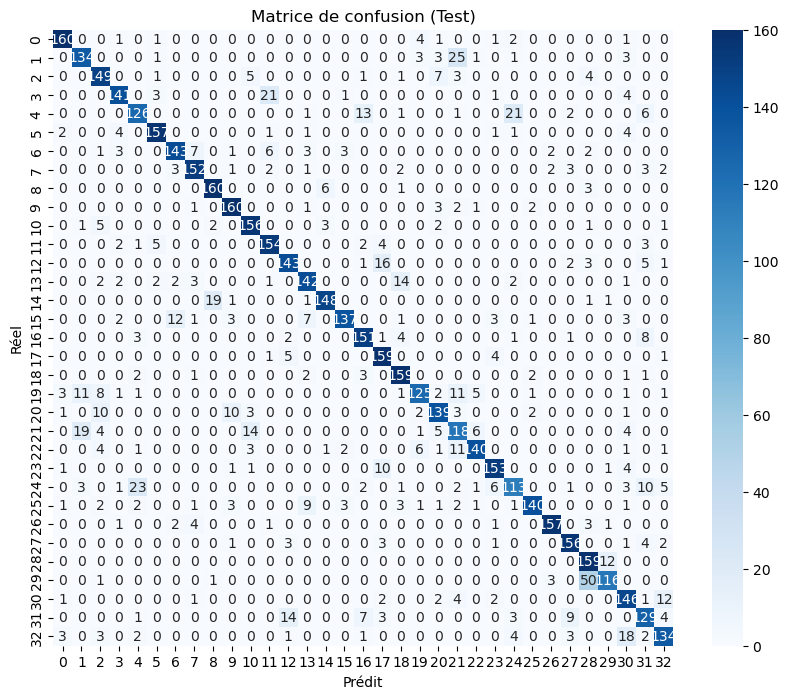

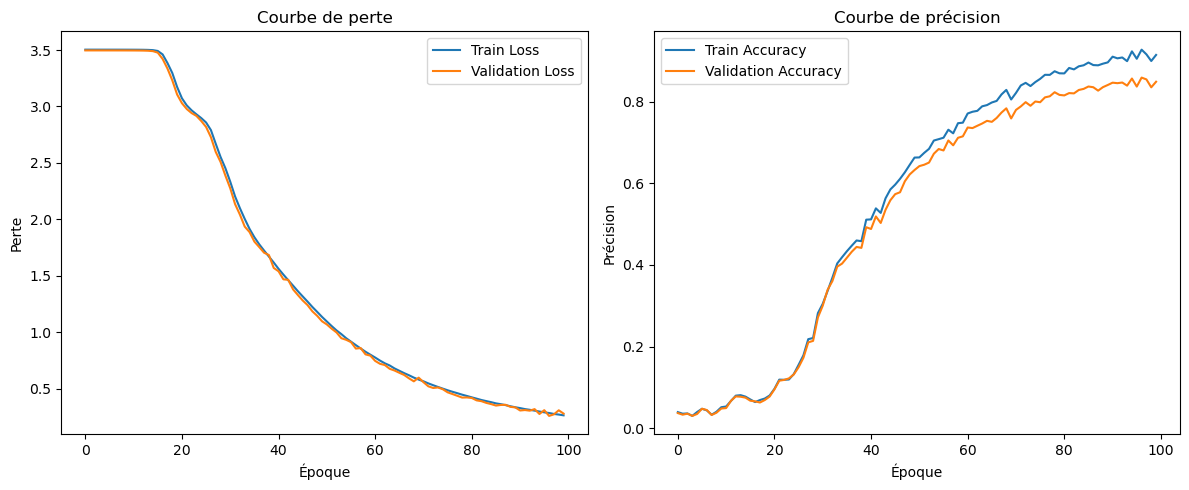

In [59]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#Fonctions d'activation
def relu(x):
    assert isinstance(x,np.ndarray), "Input to ReLU must be a numpy array"
    result=np.maximum(0,x)
    assert np.all(result>=0),"ReLU output must be non-negative"
    return result
def relu_derivative(x):
    assert isinstance(x,np.ndarray),"Input to ReLU derivative must be a numpy array"
    result=(x>0).astype(float)
    assert np.all((result==0)|(result==1)),"ReLU derivative must be 0 or 1"
    return result
def softmax(x):
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    result = exp_x / np.sum(exp_x,axis=1,keepdims=True)
    assert np.all((result>=0)&(result<=1)), "Softmax output must be in [0, 1]"
    assert np.allclose(np.sum(result,axis=1), 1), "Softmax output must sum to 1 per sample"
    return result
# Réseau de Neurones Multiclasses
class MultiClassNeuralNetwork:
    def __init__(self,layer_sizes,learning_rate=0.01):
        self.layer_sizes=layer_sizes
        self.learning_rate=learning_rate
        self.weights=[]
        self.biases=[]
        np.random.seed(42)
        for i in range(len(layer_sizes)-1):
            w=np.random.randn(layer_sizes[i],layer_sizes[i+1])*0.01
            b=np.zeros((1,layer_sizes[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    def forward(self, X):
        self.activations=[X]
        self.z_values=[]
        A=X
        for i in range(len(self.weights)-1):
            Z=A@self.weights[i]+self.biases[i]
            self.z_values.append(Z)
            A=relu(Z)
            self.activations.append(A)
        Z=A@self.weights[-1]+self.biases[-1]
        self.z_values.append(Z)
        A=softmax(Z)
        self.activations.append(A)
        return A
    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        return loss

    def compute_accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [None] * len(self.weights)
        self.d_biases = [None] * len(self.biases)
        dZ = outputs - y
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in reversed(range(len(self.weights) - 1)):
            dA = dZ @ self.weights[i + 1].T
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.d_weights[i]
            self.biases[i] -= self.learning_rate * self.d_biases[i]

    def train(self, X, y, X_val, y_val, epochs, batch_size):
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[indices], y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch=X_shuffled[i:i+batch_size]
                y_batch=y_shuffled[i:i+batch_size]
                outputs=self.forward(X_batch)
                epoch_loss+=self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
            train_loss = epoch_loss/(X.shape[0]//batch_size)
            train_pred=self.forward(X)
            val_pred=self.forward(X_val)
            train_losses.append(train_loss)
            val_losses.append(self.compute_loss(y, train_pred))
            train_accuracies.append(self.compute_accuracy(y, train_pred))
            val_accuracies.append(self.compute_accuracy(y_val, val_pred))
            if epoch%10==0:
                print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, Val Acc = {val_accuracies[-1]:.4f}")
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        outputs=self.forward(X)
        return np.argmax(outputs, axis=1)
# Chargement et prétraitement des donnée 
data_dir=os.path.join(os.getcwd(), "amhcd-data-64/tifinagh-images")
labels_df=pd.DataFrame()
if os.path.exists(os.path.join(data_dir, "labels-map.csv")):
    labels_df=pd.read_csv(os.path.join(data_dir, "labels-map.csv"))
else:
    image_paths, labels = [], []
    for label_dir in os.listdir(data_dir):
        label_path=os.path.join(data_dir,label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path,img_name))
                labels.append(label_dir)
    labels_df=pd.DataFrame({"image_path":image_paths,"label": labels})
label_encoder=LabelEncoder()
labels_df["label_encoded"]=label_encoder.fit_transform(labels_df["label"])
num_classes=len(label_encoder.classes_)
def load_and_preprocess_image(image_path,target_size=(32,32)):
    img=cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img,target_size)
    return img.astype(np.float32).flatten()/255.0
X=np.array([load_and_preprocess_image(path) for path in labels_df["image_path"]])
y=labels_df["label_encoded"].values
X_temp,X_test,y_temp,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
X_train, X_val, y_train, y_val=train_test_split(X_temp,y_temp,test_size=0.25,stratify=y_temp,random_state=42)
# Encodage One-Hot compatible avec toutes les versions
if sklearn.__version__>="1.2":
    one_hot=OneHotEncoder(sparse_output=False)
else:
    one_hot=OneHotEncoder(sparse=False)
y_train_one_hot=one_hot.fit_transform(y_train.reshape(-1,1))
y_val_one_hot=one_hot.transform(y_val.reshape(-1,1))
y_test_one_hot=one_hot.transform(y_test.reshape(-1,1))
# Entraînement 
layer_sizes=[X.shape[1],64,32,num_classes]
nn=MultiClassNeuralNetwork(layer_sizes,learning_rate=0.01)
train_losses,val_losses,train_accuracies,val_accuracies=nn.train(
    X_train,y_train_one_hot,X_val, y_val_one_hot,epochs=100,batch_size=32)
# Évaluation 
y_pred = nn.predict(X_test)
print("\nClassification report:")
print(classification_report(y_test,y_pred,target_names=label_encoder.classes_))
# Matrice de confusion 
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.savefig('confusion_matrix.png')
plt.close()
#Courbes de perte et précision 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Courbe de précision')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Précision')
ax2.legend()
plt.tight_layout()
fig.savefig('loss_accuracy_plot.png')
plt.close()
# Matrice de confusion 
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.show()
# Courbes de perte et précision 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Courbe de précision')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Précision')
ax2.legend()
plt.tight_layout()
plt.show()  

In [73]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import cv2
class TifinaghClassifierApp:
    def __init__(self, master, model, label_encoder):
        self.master = master
        self.model = model
        self.label_encoder = label_encoder
        master.title("Classification de caractères Tifinagh")
        self.label = tk.Label(master, text="Choisissez une image de caractère Tifinagh :")
        self.label.pack()
        self.load_button = tk.Button(master, text="Charger une image", command=self.load_image)
        self.load_button.pack()
        self.canvas = tk.Canvas(master, width=200, height=200)
        self.canvas.pack()
        self.result_label = tk.Label(master, text="", font=("Arial", 16))
        self.result_label.pack()
        self.image = None
    def load_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Images", "*.png *.jpg *.jpeg *.bmp")])
        if not file_path:
            return
        # Charger et afficher l’image
        pil_img = Image.open(file_path).convert("L")  # niveaux de gris
        pil_img_resized = pil_img.resize((200, 200))
        self.image = pil_img_resized
        img_tk = ImageTk.PhotoImage(pil_img_resized)
        self.canvas.create_image(0, 0, anchor="nw", image=img_tk)
        self.canvas.image = img_tk
        # Prédiction
        try:
            pred_label = self.predict_image(file_path)
            self.result_label.config(text=f"Prédiction : {pred_label}")
        except Exception as e:
            messagebox.showerror("Erreur", f"Impossible de prédire : {e}")
    def predict_image(self, image_path):
        # Même prétraitement que dans ton code
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (32, 32))
        img = img.astype(np.float32).flatten() / 255.0
        img = img.reshape(1, -1)
        pred_idx = self.model.predict(img)[0]
        pred_label = self.label_encoder.inverse_transform([pred_idx])[0]
        return pred_label
if __name__ == "__main__":
    import os
    root = tk.Tk()
    app = TifinaghClassifierApp(root, nn, label_encoder)
    root.mainloop()
